In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix



In [2]:
df_train = pd.read_csv("training_data.csv")
df_test = pd.read_csv("test_data.csv")

**Data Preparation**

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        parameterName_idx = cat_attribs.index("standard_lab_parameter_name")
        print("Before combinaiton:{}".format(X.shape))
        unit_idx = cat_attribs.index("unit")
        parameter_unit = X[:, parameterName_idx] + "_" + X[:, unit_idx]
        
        X = np.delete(X, [unit_idx, parameterName_idx], 1)
        combined = np.c_[X, parameter_unit]
        print("After combinaiton:{}".format(combined.shape))
        return combined
    
class CleanUnit(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def get_cleanedUnit(self, raw_unit):
        updated = raw_unit.lower()
        updated = updated.replace('μ', 'u').replace("micro", "u")

        updated = re.sub('[^0-9a-zA-Z/μ]+', '', updated)

        updated = updated.replace('iu', 'u').replace("ui", "ul")
        return updated
    
    def transform(self, X, y=None):
        unit_idx = cat_attribs.index("unit")
        parameter_cleaned = [ self.get_cleanedUnit(eachUnit) for eachUnit in X[:, unit_idx] ]
        print("Before cleanUnit X:{}".format(X.shape))
        X[:, unit_idx] = parameter_cleaned
        print("After cleanUnit X:{}".format(X.shape))
        return X

In [4]:
possible_cat = {"parameter_unit":[], "age_group":[]}
cleanUnit_obj = CleanUnit()
cleaned_units = df_train["unit"].apply(cleanUnit_obj.get_cleanedUnit)
possible_cat["parameter_unit"] = list(set(
        (df_train["standard_lab_parameter_name"] + "_" + cleaned_units).tolist()
    ))
possible_cat["age_group"] = list(set( df_train["age_group"].tolist() ))

In [5]:
num_attribs = ["reference_high", "reference_low", "parameter_value"]
cat_attribs = ["unit", "standard_lab_parameter_name", "age_group"]
target_field = ["gender"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])
cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('unit_cleaner', CleanUnit()),
        ('attribs_adder', CombinedAttributesAdder()),
        ('one_hot_encoder', OneHotEncoder(sparse=False)),
    ])
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [6]:
X_prepared = full_pipeline.fit_transform(df_train.copy())
print(X_prepared.shape)

encoder = LabelEncoder()
y_raw = df_train["gender"].str.lower()
y_prepared = encoder.fit_transform(y_raw)
print(y_prepared.shape)
(unique, counts) = np.unique(y_prepared, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

Before cleanUnit X:(10000, 3)
After cleanUnit X:(10000, 3)
Before combinaiton:(10000, 3)
After combinaiton:(10000, 2)
(10000, 31)
(10000,)
[[   0 1158]
 [   1 8842]]


In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
print(" Before split set : x={}, y={}".format(X_prepared.shape, y_prepared.shape))
for train_index, test_index in sss.split(X_prepared, y_prepared):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_prepared[train_index], X_prepared[test_index]
    y_train, y_test = y_prepared[train_index], y_prepared[test_index]

print(" Training set : x={}, y={}".format(X_train.shape, y_train.shape))
print(" Testing set : x={}, y={}".format(X_test.shape, y_test.shape))

 Before split set : x=(10000, 31), y=(10000,)
TRAIN: [8321 7515 7639 ... 2904 1234 6489] TEST: [6190 3324 3719 ... 5239  591 9053]
 Training set : x=(8000, 31), y=(8000,)
 Testing set : x=(2000, 31), y=(2000,)


In [8]:
(unique, counts) = np.unique(y_train, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)
(unique, counts) = np.unique(y_test, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0  926]
 [   1 7074]]
[[   0  232]
 [   1 1768]]


In [9]:
# Validate Fetures
# print(df_work["age_group"].value_counts())
# print(df_work["parameter_unit"].value_counts())

**Model Training**

In [10]:


# model_used = SGDClassifier(random_state=42)

model_used = DecisionTreeClassifier(random_state=42)

# model_used = RandomForestClassifier(max_depth=15, random_state=42)
model_used.fit(X_train, y_train)



DecisionTreeClassifier(random_state=42)

In [11]:
def evaluate_model(model, X, y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    f1 = f1_score(y_actual, y_pred, average="macro")
    precision = precision_score(y_actual, y_pred, average="macro")
    recall = recall_score(y_actual, y_pred, average="macro")

    print("Accuracy: {} \nPrecission: {} \nRecall: {} \nF1 Score: {}".format(accuracy, precision, recall, f1))

    plot_confusion_matrix(model, X, y_actual)
    


Training set evaluation

 Prediction y:(8000,)
Accuracy: 0.927875 
Precission: 0.8668577499492431 
Recall: 0.7452272520488437 
F1 Score: 0.7899021110422872


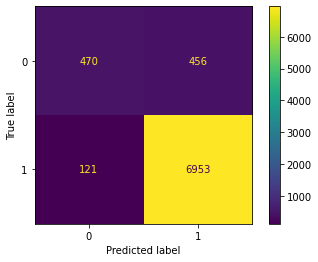

In [12]:
y_train_predict = model_used.predict(X_train)
print(" Prediction y:{}".format(y_train_predict.shape))
evaluate_model(
    model = model_used, 
    X = X_train, 
    y_actual = y_train, 
    y_pred = y_train_predict)

Testing Set Evaluation

 Prediction y:(2000,)
Accuracy: 0.856 
Precission: 0.6021312260536398 
Recall: 0.5665470432204712 
F1 Score: 0.5772861772579964


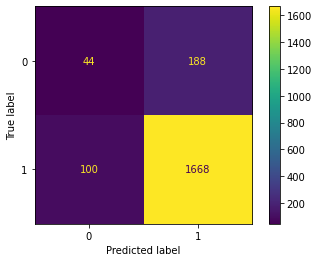

In [13]:
y_test_predict = model_used.predict(X_test)
print(" Prediction y:{}".format(y_test_predict.shape))
evaluate_model(
    model = model_used, 
    X = X_test, 
    y_actual = y_test, 
    y_pred = y_test_predict)

**Model Prediction**

In [14]:
def test_data_validation(df, possible_cat):
    cleanUnit_obj = CleanUnit()
    cleaned_units = df["unit"].apply(cleanUnit_obj.get_cleanedUnit)
    param_unit_col = (df["standard_lab_parameter_name"] + "_" + cleaned_units)
    age_group_col = df["age_group"]
    
    rm_indices_param = param_unit_col[~param_unit_col.isin(possible_cat["parameter_unit"])].index.tolist()
    rm_indices_age = age_group_col[~age_group_col.isin(possible_cat["age_group"])].index.tolist()
    print("Removed : {} instances due to parameter_unit mismatch".format(len(rm_indices_param)))
    print("Removed : {} instances due to age_group mismatch".format(len(rm_indices_age)))
    rm_indices = list(set(rm_indices_param + rm_indices_age))
    print("Total dropped cols = {}".format(len(rm_indices)))
    
    df_filtered = df.drop(df.index[rm_indices])
    df_removed  = df[df.index.isin(rm_indices)]
    
    return df_filtered, df_removed
    
df_test_filtered, df_test_removed = test_data_validation(df_test, possible_cat)

Removed : 234 instances due to parameter_unit mismatch
Removed : 0 instances due to age_group mismatch
Total dropped cols = 234


In [15]:
test_size = df_test_filtered.shape[0]
col_used = list(df_train.columns)
col_used.remove("gender")
df_test_updated = pd.concat([df_train[col_used], df_test_filtered[col_used]]).reset_index(drop=True)

X_test_ext = full_pipeline.fit_transform(df_test_updated.copy())[len(df_test_updated) - test_size:]
# print(X_test_ext.shape)

Before cleanUnit X:(19766, 3)
After cleanUnit X:(19766, 3)
Before combinaiton:(19766, 3)
After combinaiton:(19766, 2)


In [16]:
y_test_predict = model_used.predict(X_test_ext)

In [17]:
y_test_predict

array([1, 1, 1, ..., 1, 1, 1])